In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!


In [10]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [11]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]

In [13]:
x1, y1 = 0, 8
x2, y2 = 3, 16.5
m_div = (y2 - y1)/(x2 - x1)
b_div = y1 - m_div * x1

In [52]:
afterExclude_df = df[df['mg'] < m_div*(df['bp_rp']) + b_div]  
print(afterExclude_df)

               mg     bp_rp    parallax
0       10.390250  2.731872   10.000008
1        8.608481  2.025819   10.000029
2        4.267759  0.880858   10.000032
3       10.506658  2.649735   10.000066
4       12.077941  2.940875   10.000111
...           ...       ...         ...
227624  11.758283  2.834036  336.026602
227625   9.521769  2.215609  392.752945
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[214780 rows x 3 columns]


In [ ]:
def linear_model(BP_RP=None, MG=None):
    # priors
    m = m_div
    b = b_div
    σ = numpyro.sample('sigma', dist.HalfNormal(scale=20)) 

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ", m * BP_RP + b)

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("afterExclude_df", len(MG)):
        obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=BP_RP)

In [43]:
# Preparing data
BP_RP = afterExclude_df['bp_rp'].values
MG = afterExclude_df['mg'].values

# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP, 
         MG)
mcmc.print_summary()

C:\Users\rabin\AppData\Local\Temp\ipykernel_25420\2044537780.py:11: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1971.15it/s, 3 steps of size 1.10e+00. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma     13.64      0.21     13.63     13.31     13.99    626.54      1.00

Number of divergences: 0


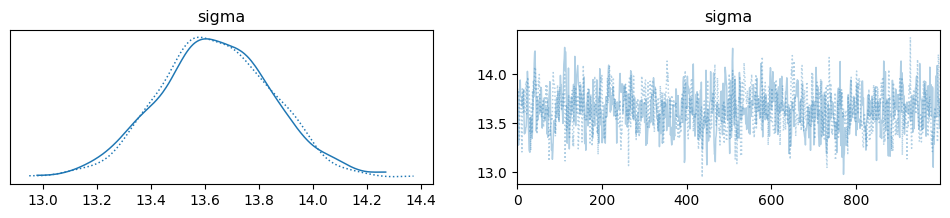

In [46]:
az.plot_trace(mcmc, var_names=["~μ"]);

In [47]:
def quad_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**2 + b*BP_RP+ c) #I have commented out this line to make you pasue and reflect. What is this line doing? Does it make sense?

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("afterExclude_df", len(MG)):
        obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [48]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(quad_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

C:\Users\rabin\AppData\Local\Temp\ipykernel_25420\3037220391.py:7: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(
sample: 100%|██████████| 6000/6000 [00:18<00:00, 316.78it/s, 147 steps of size 3.06e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.07      0.02      1.07      1.04      1.10   2486.47      1.00
         b     -5.50      0.13     -5.51     -5.71     -5.27   2451.51      1.00
         c     18.30      0.21     18.30     17.95     18.63   2533.22      1.00
   scatter      0.76      0.01      0.76      0.74      0.78   3829.65      1.00

Number of divergences: 0


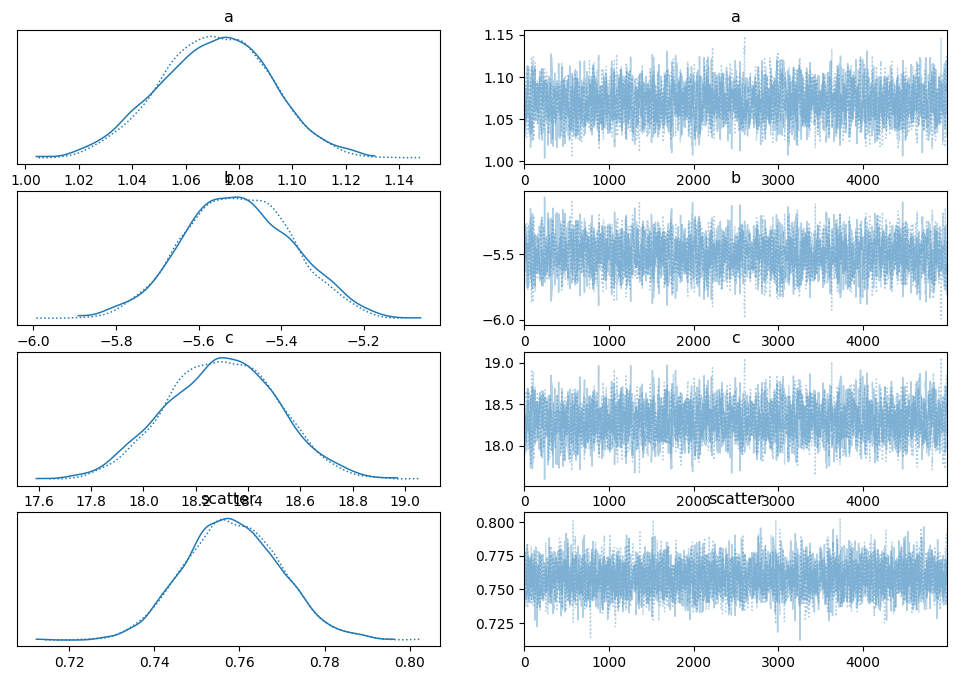

In [49]:
az.plot_trace(mcmc, var_names=["~μ"]);